## A simple but effective decision tree


Let's start with importing the libraries and the data:

In [1]:
import numpy as np
from sklearn import tree

# Load the training data from a CSV file
training_data = np.genfromtxt('phishing.csv', delimiter=',', dtype=np.int32)

The csv has 10.000 samples with 49 rows, where the last one is the label of the sample, while the other values are the features.


In [2]:
# inputs are in all columns except the last one
inputs = training_data[:,:-1]

# outputs in the last column
outputs = training_data[:, -1]

Now we split the data in the training and test sets: for now, I will use 8.000 of the samples for training and 2.000 for the test.


In [24]:
# separate training (70%) and test data (30%)
training_inputs = inputs[:7000]
training_outputs = outputs[:7000]
test_inputs = inputs[7000:]
test_outputs = outputs[7000:]

Here is one of the reasons why I like working with sklearn: we can create a classifier in few lines. Here is the code for a decision tree with default parameters:


In [4]:
# Create a decision tree classifier with default parameters
classifier = tree.DecisionTreeClassifier()

# Train the classifier
classifier.fit(training_inputs, training_outputs)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Now that we have a classifier, let's try to use it to make predictions on the test data.


In [5]:
# Use the trained classifier to make predictions on the test data
predictions = classifier.predict(test_inputs)

In order to evaluate how good is our classifier, I will use AUC (Area Under Curve), you can find more information about it [in this video](https://www.youtube.com/watch?v=OAl6eAyP-yo).


In [6]:
# importing metrics
import sklearn.metrics as metrics

false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(test_outputs, predictions)
ROC_AUC = metrics.auc(false_positive_rate, true_positive_rate)
print("ROC AUC: ", str(ROC_AUC))

ROC AUC:  0.9443533820684948


Not bad, but we can probably improve the results with some tuning

## Training/test set tuning

Let's change the size of the training and test sets to see how this affects the performance of the classifier. The classifier will be tested with the following configurations:
- 10% training, 90% test
- 20% training, 80% test
- 30% training, 70% test
- 40% training, 60% test
- 50% training, 50% test
- 60% training, 40% test
- 70% training, 30% test
- 80% training, 20% test
- 90% training, 10% test

In [34]:
split_sets = [10,20,30,40,50,60,70,80,90]

# save the training and test performance for every iteration
test_results = []
training_results = []

Now, for every option in the `split_sets` array, let's train a classifier and store the results.


In [35]:
for split in split_sets:

    # spliting the sets based on the split value
    training_inputs = inputs[:split*100]
    training_outputs = outputs[:split*100]
    test_inputs = inputs[split*100:]
    test_outputs = outputs[split*100:]

    # build and train the classifier
    classifier = tree.DecisionTreeClassifier()
    classifier.fit(training_inputs, training_outputs)

    # predict samples from training set
    training_predictions = classifier.predict(training_inputs)
    false_positive_rate, true_positive_rate, thresholds = \
        metrics.roc_curve(training_outputs, training_predictions)
    training_roc_auc = metrics.auc(false_positive_rate, true_positive_rate)

    # append training result to the list
    training_results.append(training_roc_auc)

    # predict samples from test set
    predictions = classifier.predict(test_inputs)
    false_positive_rate, true_positive_rate, thresholds = \
        metrics.roc_curve(test_outputs, predictions)
    test_roc_auc = metrics.auc(false_positive_rate, true_positive_rate)

    # append test result to the list
    test_results.append(test_roc_auc)

In order to visualize the results, I will use `matplotlib` to draw a line chart.


In [36]:
from matplotlib.legend_handler import HandlerLine2D
import matplotlib.pyplot as plt

Now, let's draw the lines for the AUC score in the training and test sets:


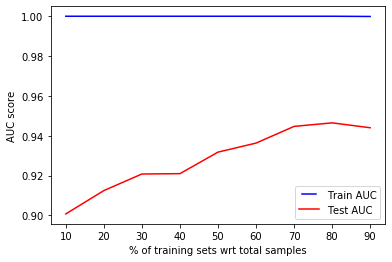

In [37]:
# a blue line for the training results
line1, = plt.plot(split_sets, training_results, 'b', label='Train AUC')

# a red line for the test results
line2, = plt.plot(split_sets, test_results, 'r', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('% of training sets wrt total samples')
plt.show()

We can clearly see how our decision tree performs better when the training set consists of 80% of the total samples.


## Criterion/splitter tuning

If we take a look at [the scikit-learn documentation for the decision tree classifiers](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), we can see that there are many parameters available. The first two are the `criterion` and `splitter`, having both two possible values. The supported criteria are `gini` (for [Gini impurity](https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity)) and `entropy` (for [information gain](https://en.wikipedia.org/wiki/Information_gain_in_decision_trees)); supported strategies for splitting a node are `best` and `random`.

In total, we have 4 possible combinations of models, let's try these combinations to check which performs better.

In [40]:
# AUC scores for test
results = []

# gini, best: default classifier
classifier = tree.DecisionTreeClassifier(criterion="gini",splitter="best")
classifier.fit(training_inputs, training_outputs)
predictions = classifier.predict(test_inputs)
false_positive_rate, true_positive_rate, thresholds = \
    metrics.roc_curve(test_outputs, predictions)
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
results.append(roc_auc)

# gini, random
classifier = tree.DecisionTreeClassifier(criterion="gini",splitter="random")
classifier.fit(training_inputs, training_outputs)
predictions = classifier.predict(test_inputs)
false_positive_rate, true_positive_rate, thresholds = \
    metrics.roc_curve(test_outputs, predictions)
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
results.append(roc_auc)

# entropy, best
classifier = tree.DecisionTreeClassifier(criterion="entropy",splitter="best")
classifier.fit(training_inputs, training_outputs)
predictions = classifier.predict(test_inputs)
false_positive_rate, true_positive_rate, thresholds = \
    metrics.roc_curve(test_outputs, predictions)
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
results.append(roc_auc)

# entropy, random
classifier = tree.DecisionTreeClassifier(criterion="entropy",splitter="random")
classifier.fit(training_inputs, training_outputs)
predictions = classifier.predict(test_inputs)
false_positive_rate, true_positive_rate, thresholds = \
    metrics.roc_curve(test_outputs, predictions)
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
results.append(roc_auc)

print("Test AUC for 'gini, best':       ",results[0])
print("Test AUC for 'gini, random':     ",results[1])
print("Test AUC for 'entropy, best':    ",results[2])
print("Test AUC for 'entropy, random':  ",results[3])



Test AUC for 'gini, best':        0.943019088305413
Test AUC for 'gini, random':      0.940023040368646
Test AUC for 'entropy, best':     0.9579833277332437
Test AUC for 'entropy, random':   0.9479991679866879


After one iteration, the best results are achieved when using `entropy` as criterion and `best` as splitter; however it is generally advisable to compare the performance on multiple iterations.


## Tuning: max depth

The next parameter of the decision tree that we can tune is `max_depth`, which indicates the maximum depth of the tree. By default, this is is set to `None`, which means that nodes are expanded until all  leaves are pure or contain less than `min_sample_split` samples.

Considering that we have 48 parameters, we will test the performances of trees having `max_depths` between 1 and 48.


In [41]:
# AUC scores for training and test
training_results = []
test_results = []

# from 1 to 48
max_depths = range(1,49)

for i in max_depths:

    # create and train the classifier
    classifier = tree.DecisionTreeClassifier(max_depth=i,criterion="entropy")
    classifier.fit(training_inputs, training_outputs)
    training_predictions = classifier.predict(training_inputs)
    false_positive_rate, true_positive_rate, thresholds = \
        metrics.roc_curve(training_outputs, training_predictions)
    
    # Calculate training AUC
    training_roc_auc = metrics.auc(false_positive_rate, true_positive_rate)

    # Add AUC score to train results
    training_results.append(training_roc_auc)
   
    # Predictions on test set
    test_predictions = classifier.predict(test_inputs)
    false_positive_rate, true_positive_rate, thresholds = \
        metrics.roc_curve(test_outputs, test_predictions)

    # Calculate test AUC
    test_roc_auc = metrics.auc(false_positive_rate, true_positive_rate)

    # Add AUC score to previous test results
    test_results.append(test_roc_auc)

Let's print a chart again to visualize the results:


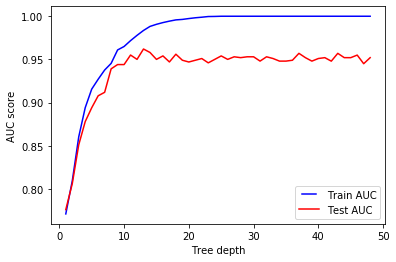

In [42]:
line1, = plt.plot(max_depths, training_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

It's possible to see that having `max_depth` more than 13 does not affect much the classifier in terms of performance regarding the test set; while having `max_depth` lower than 10 affects the AUC on both the training and test phase. 

## Tuning: min sample splits

The next parameter is `min_samples_split`.
- If `int`, it represents the minimum number of samples required to split an internal node.
- If `float`, it is considered a fraction and `ceil(min_samples_split * len(samples))` are the minimum number of samples for each split.

While the default value is 2, we will test the performance of our classifier having `min_samples_split` between 0.05 and 1.0.


In [43]:
# AUC scores for training and test
training_results = []
test_results = []

# from 5% to 100%
min_samples_splits = np.linspace(0.05, 1.0,20,endpoint=True)

for min_samples_split in min_samples_splits:

    # create and train the classifier
    classifier = tree.DecisionTreeClassifier(min_samples_split=min_samples_split)
    classifier.fit(training_inputs, training_outputs)
    training_predictions = classifier.predict(training_inputs)
    false_positive_rate, true_positive_rate, thresholds = \
        metrics.roc_curve(training_outputs, training_predictions)

    # Calculate training AUC
    training_roc_auc = metrics.auc(false_positive_rate, true_positive_rate)

    # Add AUC score to train results
    training_results.append(training_roc_auc)

    # Predictions on test set
    test_predictions = classifier.predict(test_inputs)
    false_positive_rate, true_positive_rate, thresholds = \
        metrics.roc_curve(test_outputs, test_predictions)
    test_roc_auc = metrics.auc(false_positive_rate, true_positive_rate)

    # Add AUC score to previous test results
    test_results.append(test_roc_auc)


Again, let's visualize the results with a line chart:


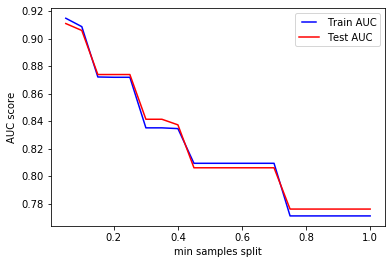

In [44]:
line1, = plt.plot(min_samples_splits, training_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_splits, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples split')
plt.show() 

We can clearly see from the chart how increasing `min_samples_split` results in an underfitting case, where the model is not able to learn from the data.

## Tuning: min samples leaf

Similarly to the previous parameter `min_samples_leaf` can be:
- `int`, and it is used to specify the minimum number of samples required to be at a leaf node
- if `float`, it represents a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node

By default, the value is set to 1, but we will consider the cases where it goes from 0.05 to 0.5.

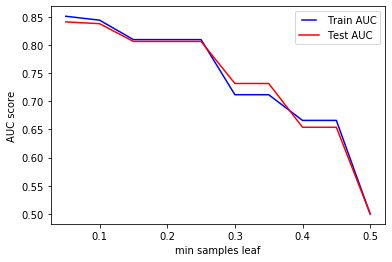

In [45]:
# AUC scores for training and test
training_results = []
test_results = []

# from 5% to 50%
min_samples_leaves = np.linspace(0.05, 0.5, 10,endpoint=True)

for min_samples_leaf in min_samples_leaves:

    # create and train the classifier
    classifier = tree.DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
    classifier.fit(training_inputs, training_outputs)
    training_predictions = classifier.predict(training_inputs)
    false_positive_rate, true_positive_rate, thresholds = \
        metrics.roc_curve(training_outputs, training_predictions)
    
    # Calculate training AUC
    training_roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    
    # Add AUC score to train results
    training_results.append(training_roc_auc)
    
    # Predictions on test set
    test_predictions = classifier.predict(test_inputs)
    false_positive_rate, true_positive_rate, thresholds = \
        metrics.roc_curve(test_outputs, test_predictions)
    test_roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    
    # Add AUC score to previous test results
    test_results.append(test_roc_auc)

line1, = plt.plot(min_samples_leaves, training_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_leaves, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples leaf')
plt.show()


Similarly to the previous parameter, increasing `min_samples_leaf` cause our model to underfit.

## Tuning: max features

The last parameter we are going to consider is `max_features`, which specifies the number of features to consider when looking for the best split.

- If `int`, then consider `max_features` features at each split.
- If `float`, is a fraction and `int(max_features * n_features)` features are considered at each split.
- By default it is `None`, and `max_features=n_features`

We will consider between 1 and 48 features.

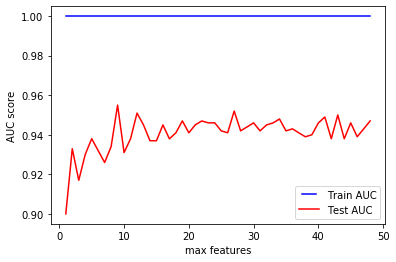

In [46]:
# AUC scores for training and test
training_results = []
test_results = []

# from 1 to 48 features
max_features = list(range(1,len(training_inputs[0])+1))

for max_feature in max_features:
    classifier = tree.DecisionTreeClassifier(max_features=max_feature)
    classifier.fit(training_inputs, training_outputs)
    training_predictions = classifier.predict(training_inputs)
    false_positive_rate, true_positive_rate, thresholds = \
        metrics.roc_curve(training_outputs, training_predictions)
    
    # Calculate training AUC
    training_roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    
    # Add AUC score to train results
    training_results.append(training_roc_auc)
    
    # Predictions on test set
    test_predictions = classifier.predict(test_inputs)
    false_positive_rate, true_positive_rate, thresholds = \
        metrics.roc_curve(test_outputs, test_predictions)
    test_roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    
    # Add AUC score to previous test results
    test_results.append(test_roc_auc)

line1, = plt.plot(max_features, training_results, 'b', label='Train AUC')
line2, = plt.plot(max_features, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('max features')
plt.show()

We can see how our model does not seems to improve after considering more than 18 features, while this may seem counter-intuitive, the scikit-learn documentation specifies that '*the search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than max_features features*.'
